# Initial Imports

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv("./kieranFeatures_1-30_26-Sep-2024.csv")
df.head()

,ID,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,...,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23,adjSA1,adjSA2,adjSA3,adjSAtotal
0,5,-0.123031,-0.226077,-1.220480,-1.697738,-0.273200,-0.601171,-0.809518,-1.012558,-0.299118,...,-1.877017,-1.442056,1.070298,1.277417,0.249605,0.400156,0.119790,1.593122,-0.800726,0.350233
1,5,-0.152896,-0.050866,1.527067,1.883468,-0.378060,-0.018812,1.023216,1.189124,-0.355315,...,-1.632698,-1.531970,1.779032,1.074498,0.409991,0.333842,0.075246,-1.663383,0.859309,-0.262893
2,5,-0.166035,-0.181478,1.634437,0.904620,-0.424192,-0.452936,1.123414,0.534554,-0.380039,...,-1.489450,-1.448590,2.194570,1.262672,0.504028,0.395338,-1.072729,0.879836,-1.542415,-0.938513
3,5,-0.231095,-0.209571,1.654951,1.247081,-0.652624,-0.546311,1.214370,0.821624,-0.502463,...,-1.353433,-1.059878,2.589134,2.139926,0.593317,0.682023,-0.643181,-0.217332,0.945816,0.145041
4,5,-0.236090,-0.323013,-0.478244,-1.080788,-0.670161,-0.923364,-0.421866,-0.775114,-0.511862,...,-1.443846,-0.627980,2.326862,3.114644,0.533965,1.000560,-0.323098,0.712401,-1.473404,-0.642872


# Randomizing All Non-Selected Features

## Pre-Processing

Divide up dataframe into predictors and outcomes. Train-test-split the following data.

Add a column for the calculated synthetic data

In [64]:
import random

# Function to calculate synthetic outcome values
def func_val_bin(predictors):
    """
        Creates a function out of five variables in the predictors dataframe
        and outputs a boolean Pandas series where True means the function value
        was greater than or equal to the median and False otherwise.

        Parameters:
            predictors (Dataframe): pandas Dataframe containing all predictor features

        Output:
            (Series): pandas Series containing True and False values where True means that
                      the calculated value was above the median and False otherwise
    """

    # Initialize array to store continuous values of function
    func_calcs = np.array([])

    # Get random coefficients and features
    random.seed(42)
    coefficients = np.array([round(random.uniform(-5, 5), 1) for _ in range(5)])
    selected_features = np.array(random.sample(list(predictors.columns), 5))

    print("Function = 1/(1+e^{-(" + 
            f"{coefficients[0]} * {selected_features[0]} + " +
            f"{coefficients[1]} * {selected_features[1]} + " +
            f"{coefficients[2]} * {selected_features[2]} + " +
            f"{coefficients[3]} * {selected_features[3]} + " +
            f"{coefficients[4]} * {selected_features[4]}" + 
            ")})")
    
    for index, row in predictors.iterrows():
        # Add new calculation to func_calcs
        func_calcs = np.append(func_calcs, 1/(1+np.e**(-(coefficients[0] * row[selected_features[0]] +
                                              coefficients[1] * row[selected_features[1]] +
                                              coefficients[2] * row[selected_features[2]] +
                                              coefficients[3] * row[selected_features[3]] +
                                              coefficients[4] * row[selected_features[4]]))))

    return pd.Series(data = (func_calcs >= 0.5).astype(int)), selected_features

In [65]:
# Create the outcome feature
synthetic_vals, selected_features = func_val_bin(df)
df["synthetic_outcome"] = synthetic_vals

Function = 1/(1+e^{-(1.4 * fNIRS_S8D6_hbr_timeToMax_version12 + -4.7 * fNIRS_S6D6_hbr_kurtosis_version17 + -2.2 * EEG_p100_poz_version11 + -2.8 * fNIRS_S7D5_hbo_kurtosis_version03 + 2.4 * fNIRS_S5D3_hbr_kurtosis_version11)})


In [68]:
predictors_df = df.iloc[:, 1:(df.shape[1] - 5)]
outcomes_df = df.iloc[:, (df.shape[1] - 5):]

display(predictors_df.loc[:, selected_features])

# Randomize data in all non-selected feature columns
for col in predictors_df.columns:
    # Don't randomize selected features
    if col in selected_features:
        continue

    max_val = np.max(predictors_df[col])
    min_val = np.min(predictors_df[col])

    random.seed(42)
    predictors_df[col] = np.array([random.uniform(min_val, max_val) for _ in range(predictors_df.shape[0])])

display(predictors_df.loc[:, selected_features])
# display(outcomes_df)

# Split into train and test
predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2, random_state = 42)

display(predictors_train)
display(outcomes_train)

# Scale the data
scaler = StandardScaler()
predictors_train = scaler.fit_transform(predictors_train)
predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
predictors_test = scaler.transform(predictors_test)
predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)

# display(predictors_train)
# display(outcomes_train)

# Free up memory
# del df
# del predictors_df
# del outcomes_df

,fNIRS_S8D6_hbr_timeToMax_version12,fNIRS_S6D6_hbr_kurtosis_version17,EEG_p100_poz_version11,fNIRS_S7D5_hbo_kurtosis_version03,fNIRS_S5D3_hbr_kurtosis_version11
0,-0.075880,-0.993371,0.062120,-0.547446,0.695366
1,-0.091050,-0.945066,0.044483,-1.126560,0.097436
2,-0.087025,-0.573242,0.062194,-0.518251,-0.208246
3,-0.076331,-0.908411,-0.146263,-0.936456,0.188304
4,-0.078068,-0.615748,0.093721,-0.425726,-0.039523
...,...,...,...,...,...
299,-0.180105,2.517705,0.070183,0.420063,0.074235
300,-0.184859,-0.690101,0.070769,0.298254,-0.391897
301,-0.180202,-0.454609,0.085638,-0.458205,0.135570
302,-0.174113,-0.513146,0.061444,0.139591,-0.473624


,fNIRS_S8D6_hbr_timeToMax_version12,fNIRS_S6D6_hbr_kurtosis_version17,EEG_p100_poz_version11,fNIRS_S7D5_hbo_kurtosis_version03,fNIRS_S5D3_hbr_kurtosis_version11
0,-0.075880,-0.993371,0.062120,-0.547446,0.695366
1,-0.091050,-0.945066,0.044483,-1.126560,0.097436
2,-0.087025,-0.573242,0.062194,-0.518251,-0.208246
3,-0.076331,-0.908411,-0.146263,-0.936456,0.188304
4,-0.078068,-0.615748,0.093721,-0.425726,-0.039523
...,...,...,...,...,...
299,-0.180105,2.517705,0.070183,0.420063,0.074235
300,-0.184859,-0.690101,0.070769,0.298254,-0.391897
301,-0.180202,-0.454609,0.085638,-0.458205,0.135570
302,-0.174113,-0.513146,0.061444,0.139591,-0.473624


,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version09,EEG_avgRelTheta_version10,EEG_avgRelTheta_version11,EEG_avgRelTheta_version12,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23
269,-1.063692,-1.061152,-4.058232,-2.620675,-3.299012,-3.136944,-2.629403,-2.068643,-2.049274,-1.922586,...,-3.777843,-3.008803,-1.999932,-1.895889,-2.912461,-2.809178,-3.274460,-3.780781,-3.178852,-2.969633
211,2.635428,2.757190,3.027665,3.873962,2.266493,2.380560,7.106412,7.644498,3.740993,3.821718,...,1.102354,1.381245,5.831184,7.476852,1.272487,1.850433,2.449474,2.110238,1.451840,1.247976
197,-0.859899,-0.850791,-3.667854,-2.262871,-2.992396,-2.832972,-2.093035,-1.533524,-1.730275,-1.606120,...,-3.508982,-2.766945,-1.568499,-1.379524,-2.681903,-2.552470,-2.959116,-3.456232,-2.923736,-2.737276
75,0.784367,0.846469,-0.518159,0.624008,-0.518518,-0.380431,2.234554,2.783987,0.843510,0.947235,...,-1.339724,-0.815560,1.912448,2.786678,-0.821685,-0.481263,-0.414816,-0.837662,-0.865385,-0.862540
177,0.953154,1.020696,-0.194837,0.920351,-0.264570,-0.128673,2.678789,3.227186,1.107713,1.209341,...,-1.117047,-0.615247,2.269773,3.214346,-0.630731,-0.268650,-0.153639,-0.568861,-0.654092,-0.670095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-0.194553,-0.164001,-2.393341,-1.094706,-1.991350,-1.840560,-0.341892,0.213540,-0.688803,-0.572914,...,-2.631200,-1.977325,-0.159947,0.306314,-1.929173,-1.714364,-1.929574,-2.396637,-2.090832,-1.978671
71,3.392358,3.538515,4.477611,5.202923,3.405331,3.509575,9.098597,9.632043,4.925822,4.997143,...,2.100961,2.279555,7.433621,9.394742,2.128829,2.803903,3.620730,3.315684,2.399392,2.111001
106,-0.569383,-0.550912,-3.111351,-1.752804,-2.555300,-2.399646,-1.328417,-0.770687,-1.275527,-1.154981,...,-3.125707,-2.422166,-0.953469,-0.643421,-2.353231,-2.186520,-2.509577,-2.993571,-2.560058,-2.406039
270,2.792846,2.919681,3.329208,4.150344,2.503336,2.615359,7.520724,8.057845,3.987400,4.066170,...,1.310033,1.568065,6.164440,7.875713,1.450579,2.048725,2.693058,2.360933,1.648901,1.427458


,adjSA1,adjSA2,adjSA3,adjSAtotal,synthetic_outcome
269,0.143670,1.101324,-0.822506,0.117187,1
211,-0.783965,-0.834554,0.116317,-0.677632,0
197,0.475912,-0.162414,1.180378,0.804260,1
75,-0.088596,0.229732,0.972713,0.618738,0
177,-1.146056,0.662741,-3.060939,-1.932524,0
...,...,...,...,...,...
188,1.116062,0.313836,0.270247,0.799881,0
71,-0.881938,0.311514,-0.739256,-0.666210,1
106,-0.900207,0.372292,-1.423042,-1.032613,0
270,-2.025591,0.753425,0.139548,-0.472791,1


## Hyperparameter Selection

In [39]:
def select_hyperparameters(model, predictors, outcome, params, eval_metric):
    """
        Conducts GridSearchCV on a Logistic Regression model to identify suitable hyperparameters

        Parameters:
            model (sklearn Model): sklearn Model to conduct GridSearchCV on
            predictors (Dataframe): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            params (dictionary): Dictionary of parameters for GridSearchCV for a LogisticRegression model
            eval_metric (string): Name of evaluation metric to use for GridSearchCV

        Return:
            clf (GridSearchCV): GridSearchCV object after running GridSearchCV with provided parameters
    """
    
    # Perform 5-fold cross-validation with different regularization strengths and regularization types
    clf = GridSearchCV(model, params, cv = 5, scoring = eval_metric, n_jobs = -1)
    clf.fit(predictors, outcome)

    # Show the best regularization strength and penaalty type
    print("Best regularization strength:", clf.best_params_["C"])
    print("Best l1_ratio:", clf.best_params_["l1_ratio"])

    return clf

In [40]:
params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": [0, 0.1, 0.5, 0.9, 1]
}

SA_func_Log_Reg = LogisticRegression(solver = "saga", penalty = "elasticnet", max_iter = 10000, fit_intercept = False)
SA_GridSearchCV_func = select_hyperparameters(SA_func_Log_Reg, predictors_train, outcomes_train["synthetic_outcome"], params, "accuracy")

Best regularization strength: 10
Best l1_ratio: 1


In [41]:
SA_GridSearchCV_func.best_score_

np.float64(0.9712585034013606)

## Fit Actual Model with Training Data

In [42]:
SA_model_func = LogisticRegression(max_iter = 15000, penalty = "elasticnet", solver = "saga", C = 10, l1_ratio = 1, n_jobs = -1, fit_intercept = False)
SA_model_func.fit(predictors_train, outcomes_train["synthetic_outcome"])
SA_model_func

LogisticRegression(C=10, fit_intercept=False, l1_ratio=1, max_iter=15000,
                   n_jobs=-1, penalty='elasticnet', solver='saga')

In [43]:
np.sum(SA_model_func.coef_ != 0)

np.int64(5783)

In [44]:
SA_model_func_coef = pd.DataFrame(
    data = {
        "coefficients": SA_model_func.coef_[0]
    },
    index = np.array(list(predictors_test.columns))
)

SA_model_func_coef.loc[["fNIRS_S8D6_hbr_timeToMax_version16", "fNIRS_S6D6_hbr_kurtosis_version19", "EEG_p100_poz_version12", "fNIRS_S7D5_hbo_kurtosis_version04", "fNIRS_S5D3_hbr_kurtosis_version12"], :]

,coefficients
fNIRS_S8D6_hbr_timeToMax_version16,-0.000022
fNIRS_S6D6_hbr_kurtosis_version19,-0.000022
EEG_p100_poz_version12,-0.000022
fNIRS_S7D5_hbo_kurtosis_version04,-0.000022
fNIRS_S5D3_hbr_kurtosis_version12,-0.000022


In [49]:
np.unique(SA_model_func.coef_)

array([-4.32439641, -2.80304687, -2.21760842, ...,  0.        ,
        1.46377086,  2.00316142])

The results above show that the coefficients above where nowhere near their actual values. Slightly suspicious of the effectiveness of regularization, but reduced a good amount of the features without removing any of the actual features used.

## Evaluate Model Performance

In [47]:
def get_eval_metrics(model, predictors, outcome):
    """
        Plots confusion matrix and ROC-AUC curve for a fitted sklearn model

        Parameters:
            model (sklearn Model): sklearn model to predict outcome values
            predictors (DataFrame): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            display_labels (list(str)): List of 2 strings for labeling the 0 and 1 outputs for confusion matrix

        Return:
            None
    """
    
    predicted_outcomes = model.predict(predictors)
    print("Accuracy: ", accuracy_score(predicted_outcomes, outcome))

    # Confusion Matrix
    cm = metrics.confusion_matrix(outcome, predicted_outcomes)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(outcome, predicted_outcomes)
    roc_auc  = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = "ROC Curve (area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--") # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Accuracy:  1.0


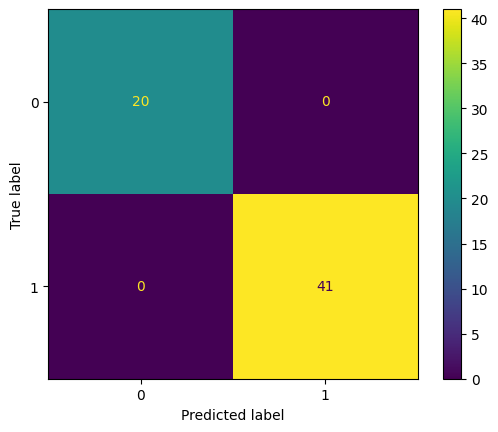

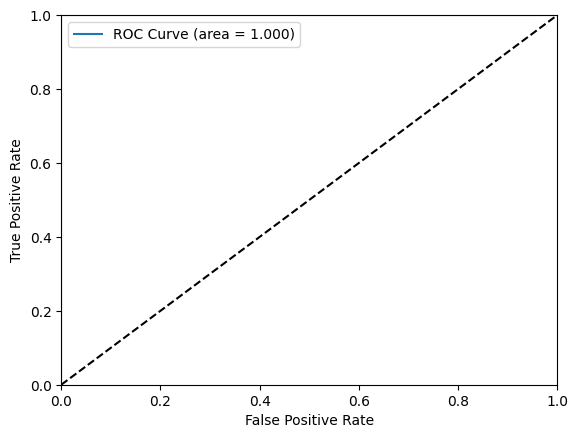

In [48]:
get_eval_metrics(SA_model_func, predictors_test, outcomes_test["synthetic_outcome"])